# Performing NER and Sentimental Analysis on Sci-Tech articles of The Hindu

In [1]:
# Import necessary packages
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.text import TextCollection
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

import spacy
from spacy import displacy
from collections import Counter
nlp = spacy.load("en_core_web_sm")

from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline
import pandas as pd
import numpy as np

from pprint import pprint
from pymongo import MongoClient

## Fetching the articles belonging to relevant collection

In [2]:
# fetch the article collection
client = MongoClient()
db = client["TheHindu"]
col = db['sci-tech']
article = []
for item in col.find():
    article.append(item['content'])
print('Number of articles found:', len(article))

Number of articles found: 45


In [3]:
# Basic exploration
corpus = ' '.join(article)
stoplist = stopwords.words('english')
tokens = [token for token in regexp_tokenize(corpus, '\w+') if len(token) > 1 and not token.isdigit() and token.lower() not in stoplist]
freqdist = nltk.FreqDist(tokens)
print('Total number of tokens found:', len(freqdist))

Total number of tokens found: 5037


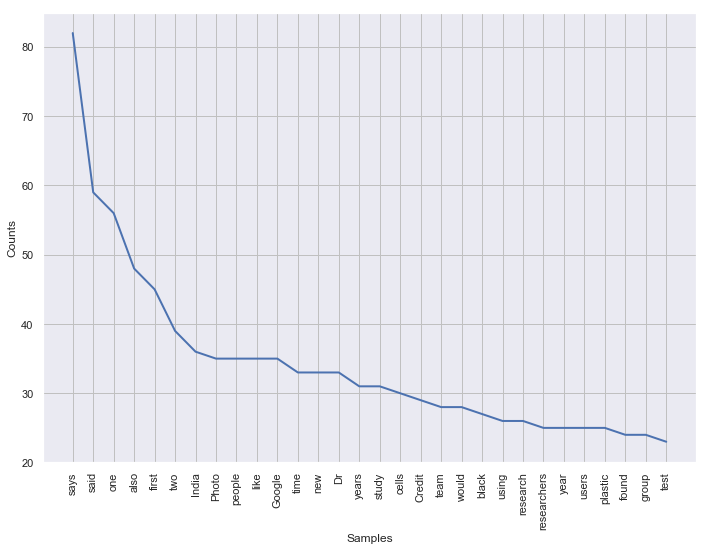

In [4]:
sb.set(rc={'figure.figsize':(11.7,8.27)})
freqdist.plot(30)

## Demonstrating NER on a single article using Spacy

In [5]:
# perform ner on each article
print(article[0])

Large number of autorickshaws parked at one of the lanes on Magadi road in Bangalore
  | Photo Credit: K_Murali Kumar In HR parlance, there is something called the ‘airport test’ carried out — either intentionally or unintentionally — by people conducting interviews after they have ascertained that the candidate has all the necessary skills to join their organisation. This test often becomes the most crucial factor that determines whether the candidate is hired or not. The airport test takes the form of questions which try to figure out if the interviewer can genuinely spend time with said candidate if they are stuck with them for an hour or two with no other company at an airport, something that might happen often enough if the job requires travelling. In a sense, this is equivalent to checking if there is a ‘culture fit’ for the organisation, but instead of being done by an HR person using some predetermined heuristics, this is a potential peer doing it better. As a parallel, there i

In [6]:
displacy.render(nlp(article[0]), jupyter=True, style='ent')

## Perfroming NER to find Named Entities in a corpus. Results are narrowed down to Persons, Organizations and GeoPolitical Entities only.

In [7]:
def getNE(text):
    ne = {}
    for x in nlp(text).ents:
        entity, label = x.text.strip(), x.label_
        if(label in ['GPE', 'PERSON', 'ORG'] and len(entity) > 1 and entity.lower() not in stoplist):
            ne[entity] = label
    return ne

In [8]:
getNE(corpus)

{'Magadi': 'GPE',
 'India': 'GPE',
 'Upstart': 'ORG',
 'America': 'GPE',
 'Amazon': 'ORG',
 'Candy Strings': 'PERSON',
 'Gummy Undies': 'ORG',
 'Tasty Pasties': 'ORG',
 'Pact Apparel': 'ORG',
 'Penny': 'PERSON',
 'eBay': 'ORG',
 'Vanity Fair': 'ORG',
 'Complex': 'ORG',
 '’m': 'PERSON',
 'Shovon Chowdhury’s': 'ORG',
 'Bengali Characteristics': 'ORG',
 'Bengal': 'GPE',
 'The Ministry of Ayurveda': 'ORG',
 'Yoga': 'PERSON',
 'Unani': 'ORG',
 'AYUSH': 'ORG',
 'Subhash C. Lakhotia': 'PERSON',
 'Banaras Hindu University': 'ORG',
 'Ministry': 'ORG',
 'Lakhotia': 'PERSON',
 'Ayurveda': 'ORG',
 'Mitali Mukerji': 'PERSON',
 'the Institute of Genomics': 'ORG',
 'Integrative Biology': 'ORG',
 'CSIR-IGIB': 'ORG',
 'Ayurvedic': 'ORG',
 'Bhavana Prasher': 'PERSON',
 'Mukerji': 'PERSON',
 'Samir K. Brahmachari': 'PERSON',
 'the Council of Scientific & Industrial Research': 'ORG',
 'Reuters': 'ORG',
 'the Rajasthan Drugs Control Organisation': 'ORG',
 'DCO': 'ORG',
 'Johnson & Johnson': 'ORG',
 'J&J': 

## Performing sentimental analysis for each entity detected in all the articles. The method also involves checking upto 3 sentences ahead if the entity is found in a sentence, to include the further sentences with pronouns for the same entity.

In [9]:
# loop through the sentences containing each NER can calculate the sentiment score and average it.
def getSentimentScore(term, corpus):
    sia = SentimentIntensityAnalyzer()
    scores = []
    sentences = sent_tokenize(corpus)
    weights = [1, 0.75, 0.5, 0.25]
    for i in range(len(sentences)):
        sentence = sentences[i]
        if term in sentence:
            scores.append(sia.polarity_scores(sentence)['compound'])
            x = i+1
            while(x < len(sentences) and x-i <= 3):
                if term in sentences[x]:
                    break
                for word, tag in pos_tag(word_tokenize(sentences[x])):
                    if tag in ['PRP', 'PRP$']:
                        scores.append(sia.polarity_scores(sentences[x])['compound'] * weights[x-i])
                        break
                x += 1

    avg_sent_score = round(sum(scores)/len(scores), 5) if len(scores)>0 else 0
    return avg_sent_score

In [10]:
# organising the enities and their scores in a dictionary on the base of entity types
nes = getNE(corpus)
sent_scores = {}
for ne in nes:
    ne_tag = nes[ne]
    if ne_tag not in sent_scores:
        sent_scores[ne_tag] = []
    sent_scores[ne_tag].append((ne, getSentimentScore(ne, corpus)))

In [11]:
# Sorting the entities in increasing order of sentiment score.
for ne_tag in sent_scores:
    sent_scores[ne_tag] = sorted(sent_scores[ne_tag], key=lambda x: x[1])

In [12]:
pprint(sent_scores)

{'GPE': [('— Bangladesh', -0.5095),
         ('Nepal', -0.5095),
         ('Pakistan', -0.5095),
         ('Ischia', -0.50528),
         ('Naples', -0.50528),
         ('Xicheng', -0.4767),
         ('Beijing', -0.4767),
         ('Virginia', -0.42956),
         ('Srinubabu Gedela', -0.2553),
         ('Italy', -0.20882),
         ('Grenoble', -0.1919),
         ('Sri Lanka', -0.148),
         ('Ecuador', -0.13758),
         ('Nevada', -0.09825),
         ('Sardinia', -0.09047),
         ('Paderu', -0.08965),
         ('Bombay', -0.08485),
         ('Hyderabad', -0.07118),
         ('Araku', -0.06653),
         ('Koramangala', -0.064),
         ('Verizon', -0.06389),
         ('Peru', -0.06046),
         ('Pseudomonas', -0.0516),
         ('CSV86', -0.0516),
         ('U.S.', -0.03755),
         ('London', -0.02568),
         ("the United States'", -0.01289),
         ('US', -0.00603),
         ('Tierpark', -0.00206),
         ('U.S', -0.00179),
         ('France', 0.0),
         ('Nag

In [13]:
print('Total NE detected:')
for ne_tag in sent_scores:
    print('{}: {}'.format(ne_tag, len(sent_scores[ne_tag])))

Total NE detected:
GPE: 107
ORG: 325
PERSON: 183


## Plotting the top and bottom N entities on the basis of sentiment score rankings.

In [14]:
def plotSentScores(data, n, features):
    if n>0:
        df = pd.DataFrame(data[-n:], columns=features)
        sb.barplot(data=df, y=features[0], x=features[1], orient='h', color='green')
    elif(n<0):
        df = pd.DataFrame(data[:abs(n)], columns=features)
        sb.barplot(data=df, y=features[0], x=features[1], orient='h', color='red')

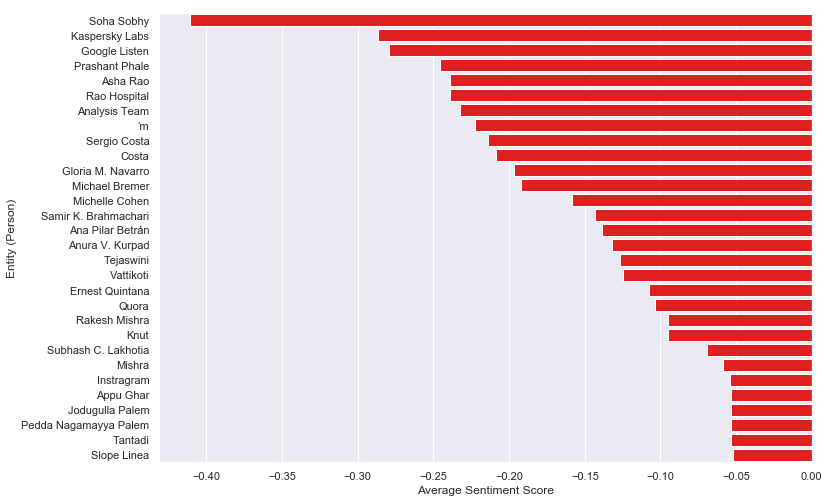

In [15]:
plotSentScores(sent_scores['PERSON'], -30, ['Entity (Person)', 'Average Sentiment Score'])

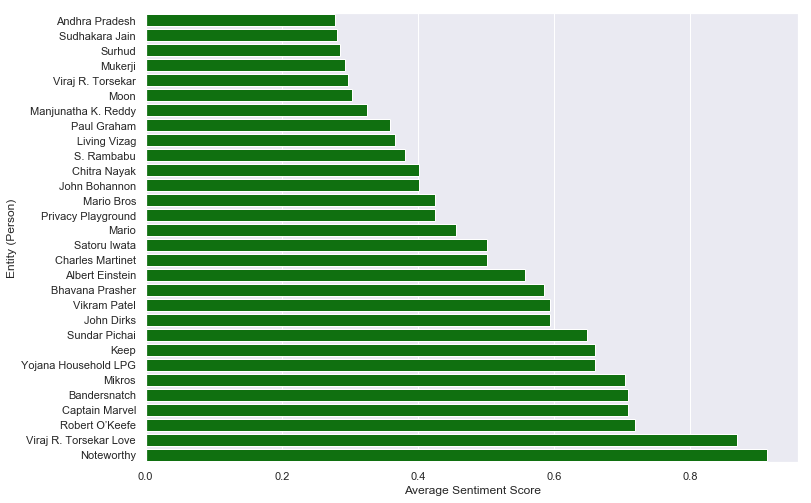

In [16]:
plotSentScores(sent_scores['PERSON'], 30, ['Entity (Person)', 'Average Sentiment Score'])

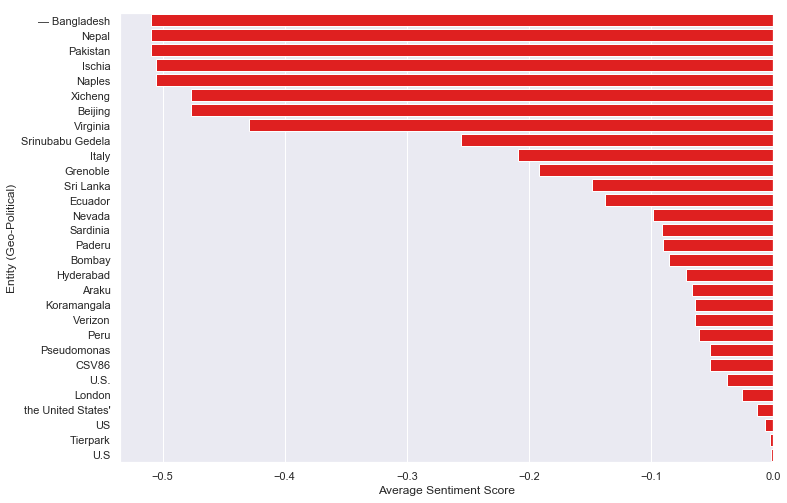

In [17]:
plotSentScores(sent_scores['GPE'], -30, ['Entity (Geo-Political)', 'Average Sentiment Score'])

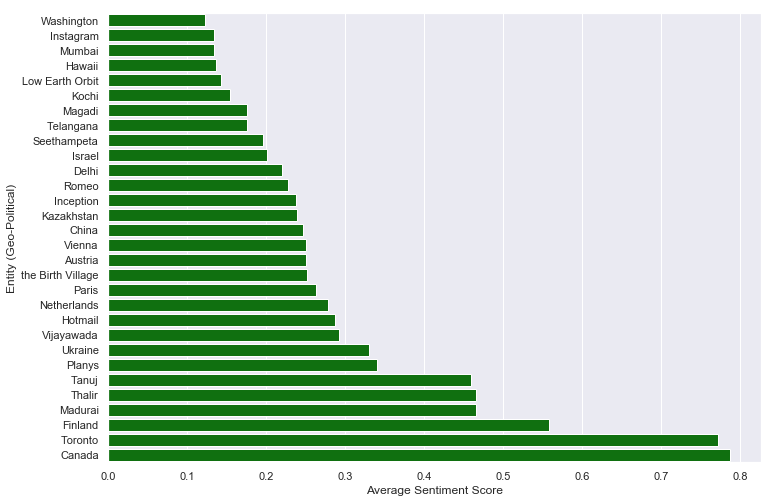

In [18]:
plotSentScores(sent_scores['GPE'], 30, ['Entity (Geo-Political)', 'Average Sentiment Score'])

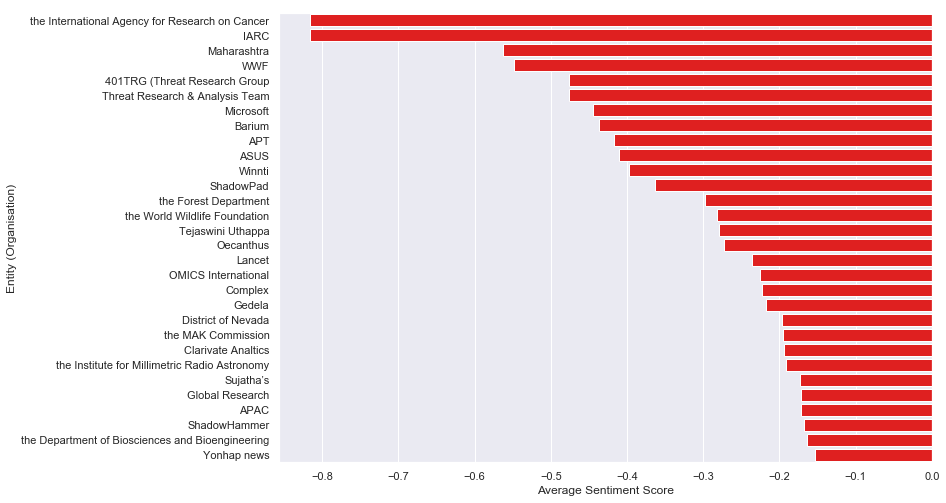

In [19]:
plotSentScores(sent_scores['ORG'], -30, ['Entity (Organisation)', 'Average Sentiment Score'])

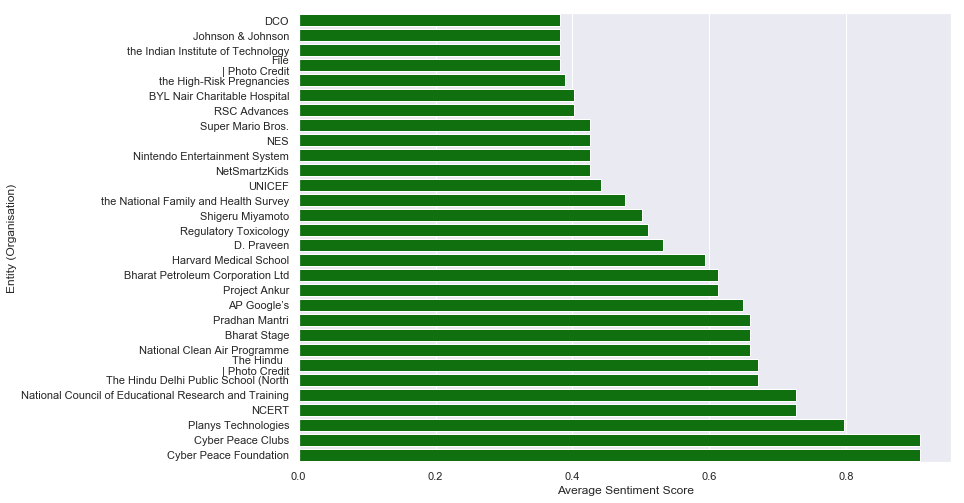

In [20]:
plotSentScores(sent_scores['ORG'], 30, ['Entity (Organisation)', 'Average Sentiment Score'])